In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns

In [102]:
flow_df = pd.read_csv('../hcr_dat_border.csv')
flow_df.head()


,iso3,Country,data_date,Border_Crossings
0,BLR,Belarus,24/Feb/2022,136
1,BLR,Belarus,25/Feb/2022,34
2,BLR,Belarus,26/Feb/2022,172
3,BLR,Belarus,27/Feb/2022,48
4,BLR,Belarus,28/Feb/2022,18


In [103]:
print(flow_df.Country.value_counts())

Country
Hungary                237
Poland                 237
Slovakia               237
Republic of Moldova    236
Romania                235
Russian Federation     222
Belarus                200
Name: count, dtype: int64


In [104]:
countries_of_interest = ['Slovakia', 'Hungary', 'Poland', 'Republic of Moldova']
flow_df = flow_df[flow_df.Country.isin(countries_of_interest)]

In [105]:
flow_df['data_date'] = pd.to_datetime(flow_df['data_date'], format='%d/%b/%Y')
flow_df.drop(columns=['iso3'], inplace=True)
flow_df.rename(columns={"data_date": 'date', ' Border_Crossings ' : 'border_crossings'}, inplace=True)
flow_df = flow_df.groupby(['date', 'Country']).sum()
flow_df.head()

border_crossings
date       Country                             
2022-02-24 Hungary                      19,978 
           Poland                       30,096 
           Republic of Moldova          10,928 
           Slovakia                      4,844 
2022-02-25 Hungary                      19,618

In [106]:
import pickle
with open("acled_2022.pkl" , mode='rb') as f:
    acled_df = pickle.load(f)

In [107]:
acled_df.head()

fatalities  event
event_date region                   
2022-02-01 South            0      0
           East             0     23
           North            0      0
           West             0      0
           Center           0      1

In [108]:
print(acled_df.dtypes)

fatalities    int64
event         int64
dtype: object


In [109]:
all_dates = pd.date_range(np.min(acled_df.index.get_level_values('event_date')), np.max(acled_df.index.get_level_values('event_date')))
all_places = list(set(acled_df.index.get_level_values('region')))
ind2 = pd.MultiIndex.from_product([all_dates,all_places], names = ['date','region'])
acled_df = acled_df.reindex(ind2, fill_value = 0) 
acled_df.index = acled_df.index.set_levels([pd.to_datetime(acled_df.index.levels[0]), acled_df.index.levels[1]])
acled_df.index.sortlevel('date')
acled_df.head()

fatalities  event
date       region                   
2022-02-01 Kyiv             0      3
           South            0      0
           East             0     23
           West             0      0
           North            0      0

In [110]:
kyiv = acled_df.xs('Kyiv', level=1)
kyiv.fatalities.idxmax()

Timestamp('2022-03-15 00:00:00')

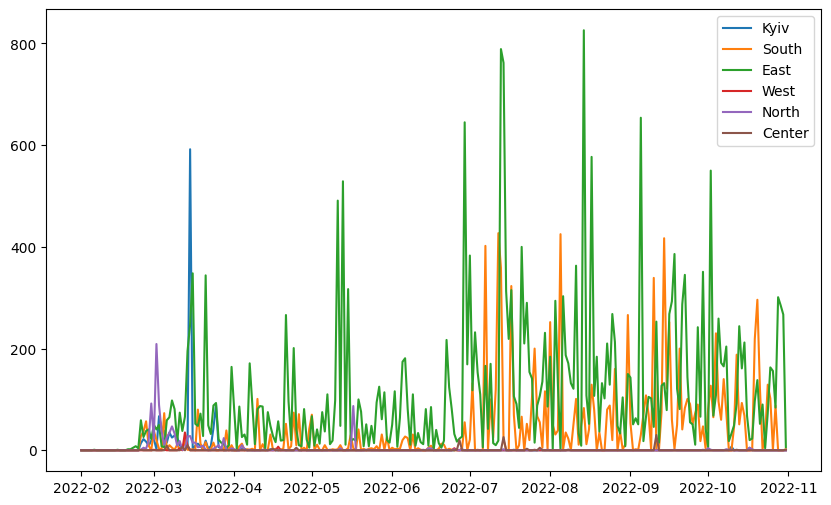

In [111]:
fig, ax = plt.subplots(figsize=(10, 6))
for r in all_places:
    plt.plot(acled_df.xs(r,level=1).loc[:,'fatalities'], label = r)
plt.legend()

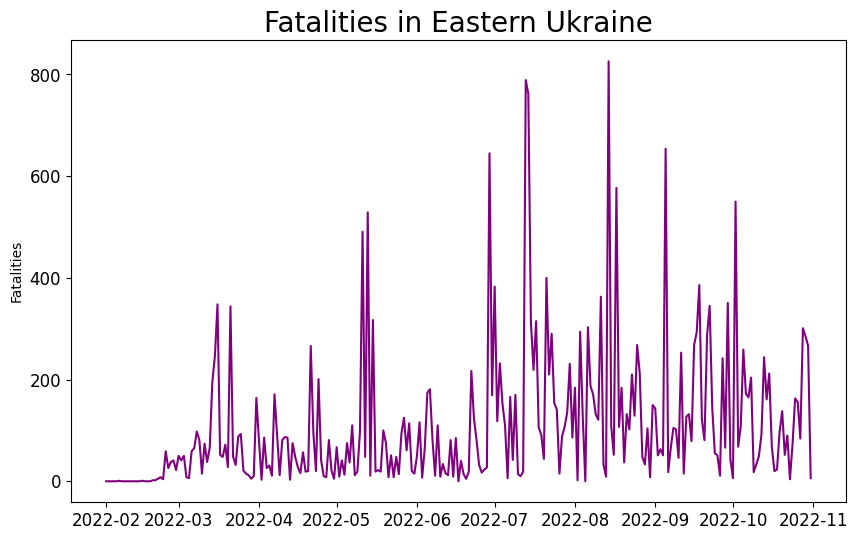

In [112]:
#east plot
fig, ax = plt.subplots(figsize=(10, 6))
r = 'East'
plt.plot(acled_df.xs(r, level=1).loc[:,'fatalities'], color='purple')
plt.title('Fatalities in Eastern Ukraine', fontsize=20)
plt.ylabel('Fatalities')
ax = plt.gca()
xtick_locator = mdates.AutoDateLocator()
xtick_formatter = mdates.AutoDateFormatter(xtick_locator)
ax.xaxis.set_major_locator(xtick_locator)
ax.xaxis.set_major_formatter(xtick_formatter)
ax.tick_params(axis='x', labelsize=12)
plt.yticks(fontsize=12)
plt.savefig('east fatalities')
plt.show()



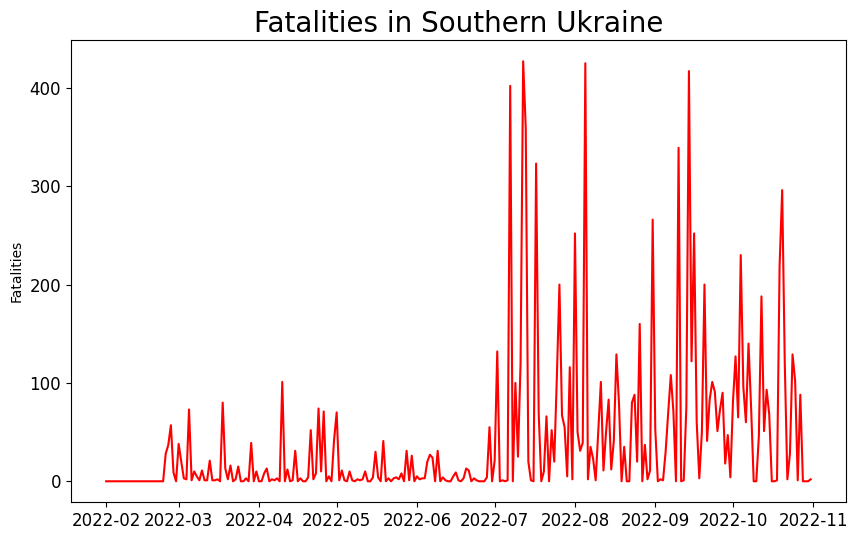

In [113]:
fig, ax = plt.subplots(figsize=(10, 6))
r = 'South'
plt.plot(acled_df.xs(r, level=1).loc[:,'fatalities'], color='red')
plt.title('Fatalities in Southern Ukraine', fontsize=20)
plt.ylabel('Fatalities')
ax = plt.gca()
xtick_locator = mdates.AutoDateLocator()
xtick_formatter = mdates.AutoDateFormatter(xtick_locator)
ax.xaxis.set_major_locator(xtick_locator)
ax.xaxis.set_major_formatter(xtick_formatter)
ax.tick_params(axis='x', labelsize=12)
plt.yticks(fontsize=12)
plt.savefig('south fatalities')
plt.show()

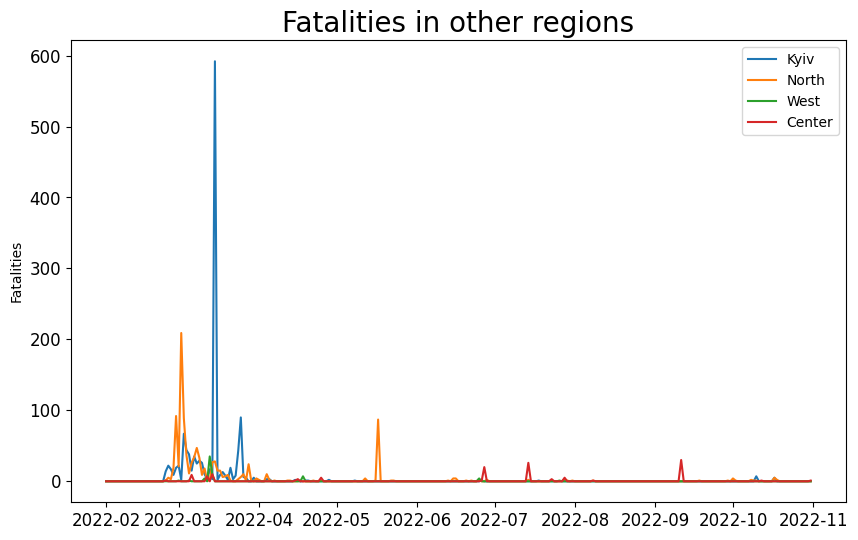

In [114]:
others = ['Kyiv', 'North', 'West', 'Center']
fig, ax = plt.subplots(figsize=(10, 6))
for r in others:
    plt.plot(acled_df.xs(r, level=1).loc[:,'fatalities'], label = r)
plt.title('Fatalities in other regions', fontsize=20)
plt.ylabel('Fatalities')
ax = plt.gca()
xtick_locator = mdates.AutoDateLocator()
xtick_formatter = mdates.AutoDateFormatter(xtick_locator)
ax.xaxis.set_major_locator(xtick_locator)
ax.xaxis.set_major_formatter(xtick_formatter)
ax.tick_params(axis='x', labelsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.savefig('all_other_fatalities')
plt.show()

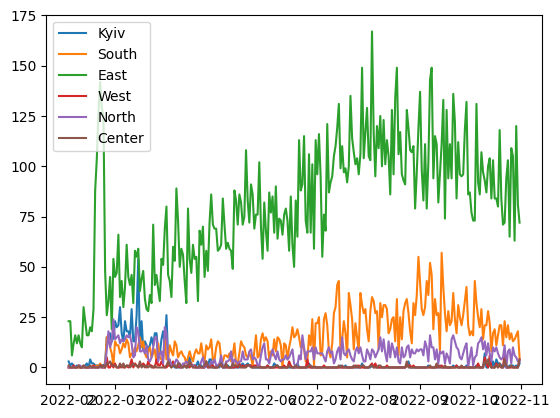

In [115]:
fig = plt.figure()
for r in all_places:
    plt.plot(acled_df.xs(r,level=1).loc[:,'event'], label = r)
plt.legend()

In [116]:
flow_df_copy = flow_df
flow_df.head()


border_crossings
date       Country                             
2022-02-24 Hungary                      19,978 
           Poland                       30,096 
           Republic of Moldova          10,928 
           Slovakia                      4,844 
2022-02-25 Hungary                      19,618

In [117]:
merged_df = flow_df.join(acled_df.reindex(acled_df.index, level=0))
merged_df.head()

border_crossings  fatalities  event
date       Country region                                    
2022-02-24 Hungary Kyiv            19,978           14     15
                   South           19,978           28     15
                   East            19,978           59     26
                   West            19,978            0      5
                   North           19,978            1      9

In [118]:
merged_df['border_crossings'] = merged_df['border_crossings'].str.replace(',', '')
merged_df['border_crossings'] = merged_df['border_crossings'].str.replace('-', '0')
merged_df['border_crossings'] = merged_df['border_crossings'].str.strip().astype('int')

In [119]:
countries = merged_df.index.get_level_values('Country').unique()
corr_matrix = np.zeros([len(countries),len(all_places)])
with open('fatality_flow_corrs.txt', 'w') as f:
    for i,c in enumerate(countries):
        for j,r in enumerate(all_places):
            flow = merged_df.xs((c, r), level=[1,2]).border_crossings
            fatalities = merged_df.xs((c, r), level=[1,2]).fatalities
            corr = np.corrcoef(flow.values, fatalities.values)[0][1]
            corr_str = c + ', ' + r + ' = ' + str(corr)
            f.write(corr_str)
            f.write('\n')
            corr_matrix[i,j] = corr


In [120]:
corr_matrix

array([[ 0.16489107, -0.00540099, -0.03010701,  0.0772038 ,  0.46062653,
         0.03725782],
       [ 0.25985308, -0.09905327, -0.09852544,  0.19719718,  0.56290028,
         0.07110272],
       [ 0.21274316, -0.08523454, -0.12731538,  0.14175547,  0.65326597,
         0.01701876],
       [ 0.24751286, -0.12705502, -0.09867137,  0.21193843,  0.56509203,
         0.06326384]])

In [121]:
fig = plt.figure()
plt.imshow(corr_matrix, cmap = plt.get_cmap('Blues'), vmin = 0, vmax = 1)
plt.colorbar()
ax = plt.gca()
#ax.set_xticklabels(vars)
ax.set_yticks(np.arange(len(countries)))
ax.set_yticklabels(countries)
ax.set_xticks(np.arange(len(all_places)))
ax.set_xticklabels(all_places)
plt.xticks(rotation=90)
#ax.xaxis.set_xticks(vars)
plt.tight_layout()
plt.savefig("corr_flow.png")
plt.close()

In [122]:
offset_range = np.arange(1, 20)
for o in offset_range:
    print(o)
    print('\n')
    for i,c in enumerate(countries):
            for j,r in enumerate(all_places):
                flow = merged_df.xs((c, r), level=[1,2]).border_crossings[:-o]
                fatalities = merged_df.xs((c, r), level=[1,2]).fatalities[o:]
                corr = np.corrcoef(flow.values, fatalities.values)[0][1]
                if abs(corr) >= 0.5:
                    print(c,r)
                    print(corr)

1


Hungary North
0.5348273571913397
Poland North
0.5711187732837193
Republic of Moldova North
0.6435622511430517
Slovakia North
0.6081217639192725
2


Hungary North
0.6068365422482632
Poland North
0.55341168191665
Republic of Moldova North
0.5748432677271184
Slovakia North
0.5940531990019765
3


Hungary North
0.5948661288432677
Poland North
0.5050112025075714
Republic of Moldova North
0.5781240325520204
Slovakia North
0.6037346030030473
4


Hungary North
0.692888787987544
Republic of Moldova North
0.5429107530088149
Slovakia North
0.5202292489601236
5


Hungary North
0.6113656293433829
Republic of Moldova North
0.5040832556889049
6


Hungary North
0.612095538737507
7


Hungary North
0.6014778562264357
Republic of Moldova North
0.5045390805721047
8


Hungary North
0.5257291061988708
Slovakia North
0.5115102207900061
9


Hungary North
0.5172741440093405
Republic of Moldova North
0.5143443826590404
Slovakia North
0.5350596406350141
10


Hungary North
0.5484384654473414
11


12


13


14


In [123]:
countries = merged_df.index.get_level_values('Country').unique()
corr_matrix = np.zeros([len(countries),len(all_places)])
with open('event_flow_corrs.txt', 'w') as f:
    for i,c in enumerate(countries):
        for j,r in enumerate(all_places):
            flow = merged_df.xs((c, r), level=[1,2]).border_crossings
            events = merged_df.xs((c, r), level=[1,2]).event
            corr = np.corrcoef(flow.values, events.values)[0][1]
            corr_str = c + ', ' + r + ' = ' + str(corr)
            f.write(corr_str)
            f.write('\n')
            corr_matrix[i,j] = corr


In [124]:
fig = plt.figure()
plt.imshow(corr_matrix, cmap = plt.get_cmap('Blues'), vmin = 0, vmax = 1)
plt.colorbar()
ax = plt.gca()
#ax.set_xticklabels(vars)
ax.set_yticks(np.arange(len(countries)))
ax.set_yticklabels(countries)
ax.set_xticks(np.arange(len(all_places)))
ax.set_xticklabels(all_places)
plt.xticks(rotation=90)
#ax.xaxis.set_xticks(vars)
plt.tight_layout()
plt.savefig("corr_flow_events.png")
plt.close()

In [125]:
flow_df_copy['border_crossings'] = flow_df_copy['border_crossings'].str.replace(',', '')
flow_df_copy['border_crossings'] = flow_df_copy['border_crossings'].str.replace('-', '0')
flow_df_copy['border_crossings'] = flow_df_copy['border_crossings'].str.strip().astype('int')
flow_df_copy = flow_df_copy.groupby(['date']).sum()
flow_df_copy.head()

,border_crossings
date,
2022-02-24,65846
2022-02-25,90155
2022-02-26,131865
2022-02-27,154046
2022-02-28,149041


In [129]:
merged_df = flow_df_copy.join(acled_df.reindex(acled_df.index, level=0))
merged_df.head()

border_crossings  fatalities  event
date       region                                     
2022-02-24 Kyiv               65846          14     15
           South              65846          28     15
           East               65846          59     26
           West               65846           0      5
           North              65846           1      9

In [130]:
#offset fatalities
offset_range = np.arange(-20, 20)
corr_dict = {'Kyiv':[], 'South':[], 'East': [], 'West': [], 'North':[], 'Center':[]}
for i in offset_range:
    for e in all_places:
            shift = merged_df.xs(e, level=1)['fatalities'].shift(i)
            print(shift)
            corr = shift.corr(merged_df.xs(e, level=1)['border_crossings'])
            corr_dict[e].append(corr**2)

date
2022-02-24     2.0
2022-02-25     9.0
2022-02-26    13.0
2022-02-27     8.0
2022-02-28     2.0
              ... 
2022-10-14     NaN
2022-10-15     NaN
2022-10-16     NaN
2022-10-17     NaN
2022-10-18     NaN
Name: fatalities, Length: 237, dtype: float64
date
2022-02-24     2.0
2022-02-25     0.0
2022-02-26    80.0
2022-02-27    13.0
2022-02-28     2.0
              ... 
2022-10-14     NaN
2022-10-15     NaN
2022-10-16     NaN
2022-10-17     NaN
2022-10-18     NaN
Name: fatalities, Length: 237, dtype: float64
date
2022-02-24    348.0
2022-02-25     52.0
2022-02-26     48.0
2022-02-27     72.0
2022-02-28     28.0
              ...  
2022-10-14      NaN
2022-10-15      NaN
2022-10-16      NaN
2022-10-17      NaN
2022-10-18      NaN
Name: fatalities, Length: 237, dtype: float64
date
2022-02-24    0.0
2022-02-25    0.0
2022-02-26    0.0
2022-02-27    0.0
2022-02-28    0.0
             ... 
2022-10-14    NaN
2022-10-15    NaN
2022-10-16    NaN
2022-10-17    NaN
2022-10-18    NaN
Name: 

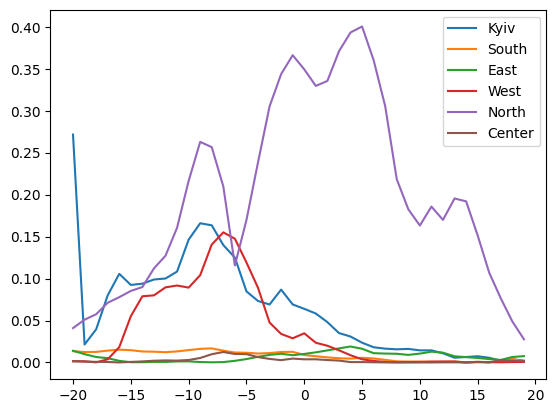

In [131]:
fig = plt.figure()
for i in all_places:
    plt.plot(offset_range, corr_dict[i], label=i)
plt.legend()
plt.show()
